# Flickr 8k dataset captions prediction

**We address the problem of image captioning, which involves describing the visual content of an image with a sentence in natural language. We will implement a simplified version of the "show and tell" approach [[VTBE15]](#vinyalstbecvpr2015).** 


## Word Embedding

To accelerate the training time of the model, we will consider a subset of the vocabulary. The following code can be used to extract a histogram of word occurrences present in the captions of the training subset of the Flickr8k dataset :


In [1]:
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
import nltk
from src.data.data_fetcher import download
from src.data.image_loader import encoded_image_loader
from src.model.model_life_cycle import save_model, load_model
from src.data.data_processing import DataPreprocessor
from src.utility.utils import sampling

Download the data from Google Drive and place it in the "data" repo.

In [2]:
tdp = DataPreprocessor()

In [3]:
nbwords, bown = tdp.prepare_train_word_dictionary()

iterating over ./data/flickr_8k_train_dataset.txt...:   0%|          | 0/30000 [00:00<?, ?it/s]

**We can calculate the cumulative frequency of the top 1000 retained words:**


In [4]:
# nbkeep = 100
nbkeep = 1000
freqnc = np.cumsum([float(w[0]) / nbwords * 100.0 for w in bown])
print(f"number of kept words={nbkeep:.2f} - ratio={freqnc[nbkeep-1]:.2f} %")

number of kept words=1000.00 - ratio=94.24 %


<BarContainer object of 100 artists>

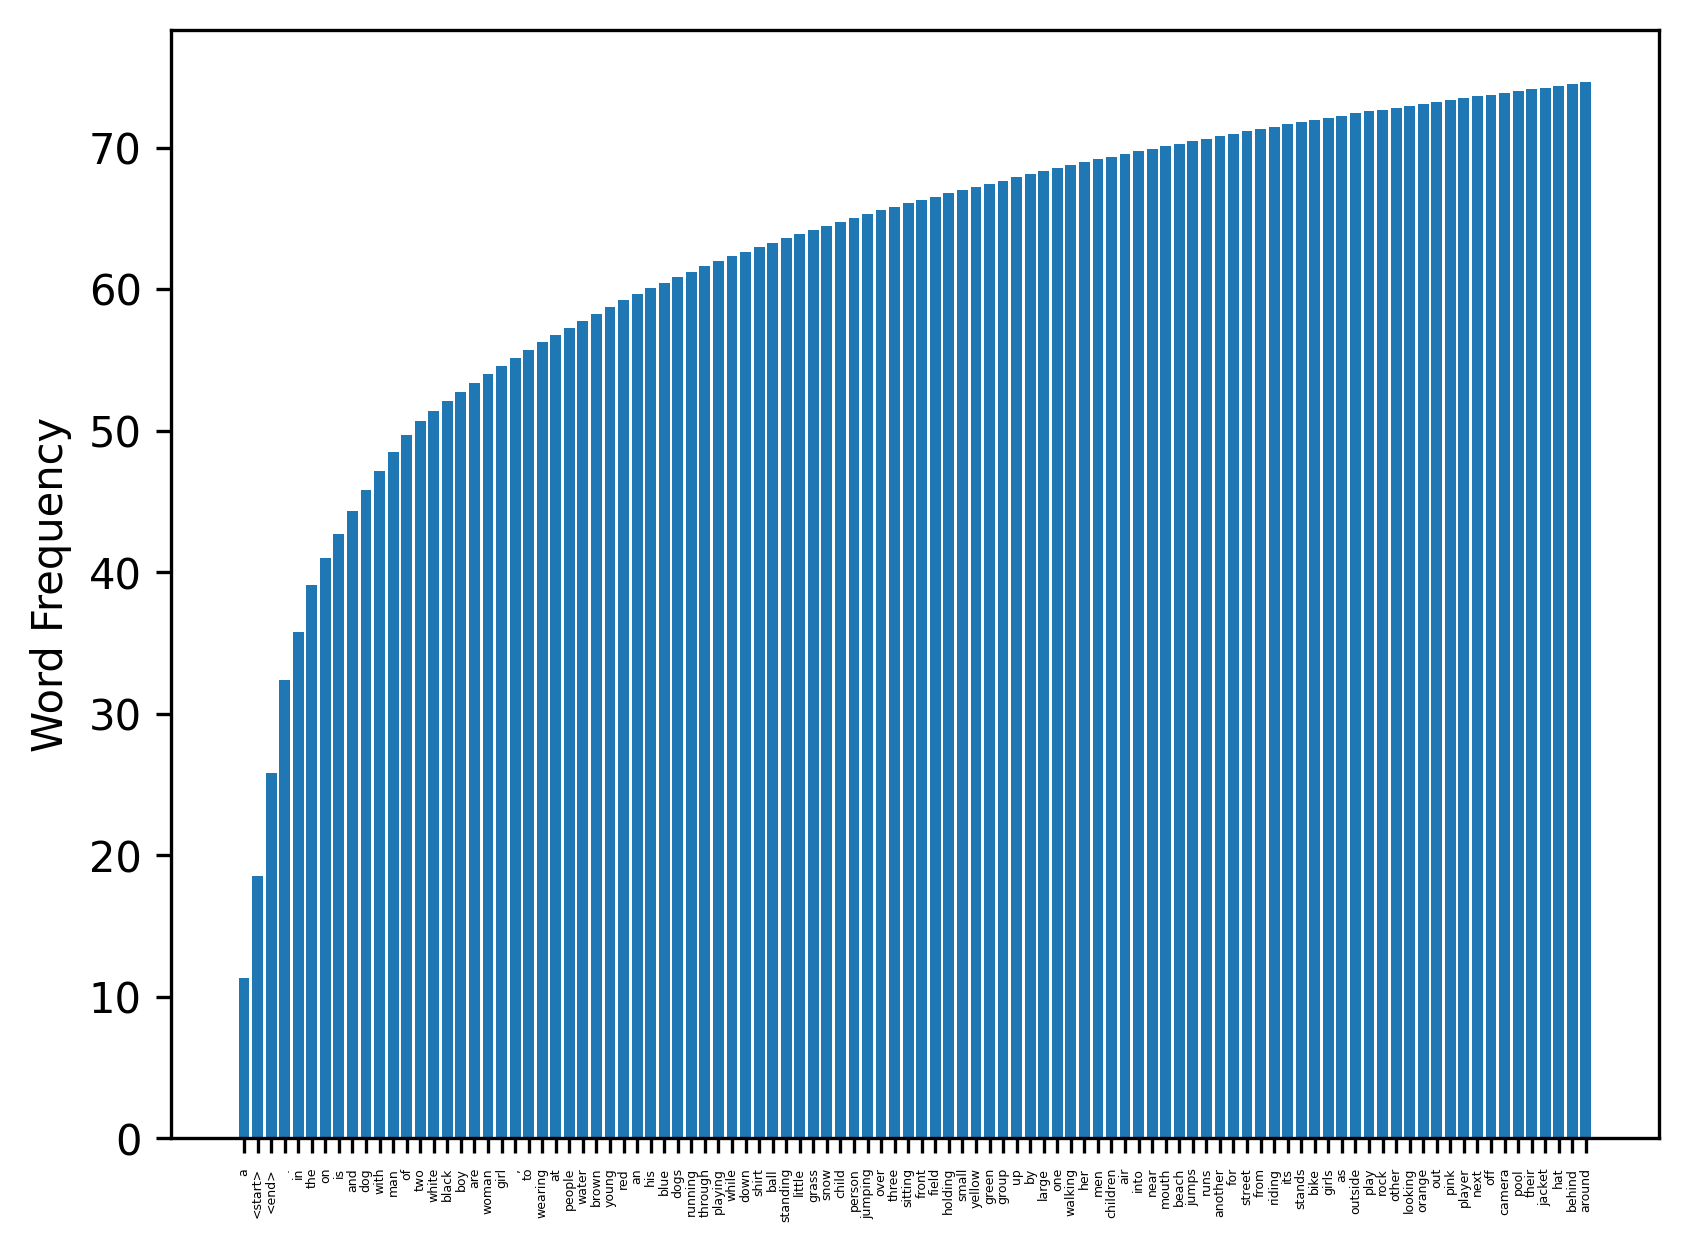

In [5]:
x_axis = [str(bown[i][1]) for i in range(100)]
plt.figure(dpi=300)
plt.xticks(rotation=90, fontsize=3)
plt.ylabel("Word Frequency")
plt.bar(x_axis, freqnc[0:100])

**We will load the embedding file and retain the `nbkeep` (=1000) most frequent words, and save the subset of words and the corresponding Glove vector embeddings:**

In [6]:
[listwords, embeddings] = pickle.load(open("./data/Caption_Embeddings.p", "rb"))

embeddings_new = np.zeros((nbkeep, 102))
listwords_new = []

for i in tqdm(
    range(nbkeep),
    desc=f"Keeping the {nbkeep} first words...",
    leave=False,
    total=nbkeep,
):
    listwords_new.append(bown[i][1])

    embeddings_new[i, :] = embeddings[
        listwords.index(bown[i][1])
    ]
    embeddings_new[i, :] /= np.linalg.norm(embeddings_new[i, :])  # Normalization

listwords = listwords_new
embeddings = embeddings_new

with open(f"./data/Caption_Embeddings_{nbkeep}.p", "wb") as pickle_f:
    pickle.dump([listwords, embeddings], pickle_f)

## Creation of Training and Test Data

**We will now store the training data, _i.e._ the tensors containing the data and labels.**
The data tensor $ \mathbf{X} $ will have the size $ N_s \times L_s \times d $ where $ N_s $ is the number of sequences (captions), $ L_s $ is the sequence length, and $ d $ is the size of the vector describing each word in the sequence.

The source files containing the image identifiers and image captions are available:

- Here for training: flickr_8k_train_dataset.txt
- Here for testing: flickr_8k_test_dataset.txt

Since we need to use fixed-size tensors with `keras`, we will determine the maximum caption length in the training data:

In [7]:
maxLCap = tdp.get_max_length_caption(listwords)
tinput = 202
print(f"Max caption length={maxLCap}")

Max caption length=35


**Each element $ e_i $ of an input sequence will be described by a vector $ x_i \in \mathbb{R}^d $ (with $ d=202 $ here) corresponding to:**

- The description of the content of the $ i^{th} $ word in the caption, for which we will use the Glove vector embedding. This will correspond to the first 102 components of $ x_i $.
- The description of the visual content of the image, obtained by calculating "Deep Features", here using a deep convolutional network of the VGG type [[SZ15]](#dblp-journals-corr-simonyanz14a). The dimension of the resulting vector (4096 here) was reduced to 100 by Principal Component Analysis (PCA). This will correspond to the last 100 components of $ x_i $. **This 100-dimensional vector for each image in the dataset is provided:** encoded_images_PCA.p

**The output of the recurrent network is a sequence of the same size as the input, where each element corresponds to the prediction of the next word.** Each output sequence will therefore always end with “<end>”. Since the vocabulary was simplified in Exercise 1, we will retain in the input and output sequences only the words in the caption that are present in the reduced dictionary.


In [8]:
encoded_images = encoded_image_loader()

In [9]:
X_train, Y_train = tdp.construct_x_train_y_train(encoded_images, embeddings, listwords)

tensor X_train, Y_train saved at : ./data/Training_data_100


**We will do the same for the test data, allocating tensors of the same size as the training ones (so we can apply the prediction model afterward).**



In [10]:
X_test, Y_test = tdp.construct_x_test_y_test(encoded_images, embeddings, listwords)

tensor X_test, Y_test saved at : ./data/Test_data_100


## Model Training

We will now define the model architecture to learn to predict the next word from a given subsequence and an image. After instantiating an empty `Sequential` model, we will define:

- A `Masking` layer, see the documentation [https://keras.io/layers/core/#masking](https://keras.io/layers/core/#masking). We need to specify the input size of each example (sequence), _i.e._ $ L_s \times d $ ($ L_s $ is the sequence length and $ d $ is the size of each element in the sequence).

> - This `Masking` layer will prevent the error from being calculated in areas where the input tensor has a given value (_e.g._ 0), which corresponds to the areas of the input sequence where no word is present (due to the need for a fixed-size tensor, hence a sequence length corresponding to the longest sequence in the training dataset).

- A `SimpleRNN` recurrent network layer. We will use 100 neurons in the hidden layer. We will use `return_sequences=True` to return the prediction for each element of the input sequence, and also `unroll=True`.
- A fully connected layer, followed by a softmax activation function.

To train the model, we will define a cross-entropy loss function, which will be directly applied to each output element. We will use the `Adam` optimizer, with the default learning rate. We will choose a batch size of 10 examples (_i.e._ 10 captions, with the classification error on each caption being calculated as an average of the predictions on each word).

- Once the model is trained, we will save it using the usual function:


In [11]:
from tensorflow.keras.layers import Dense, Activation, Masking, SimpleRNN, Input, Conv1D, LSTM, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
model = Sequential()
model.add(Input((maxLCap, tinput)))
model.add(Masking(mask_value=0.0))
model.add(LSTM(128, activation="relu", return_sequences=True, unroll=True))
model.add(Dense(1000, name="Full"))
model.add(Activation("softmax"))

In [13]:
BATCH_SIZE = 64
NUM_EPOCHS = 50
learning_rate = 0.001

model.compile(
    loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 35, 202)           0         
                                                                 
 lstm (LSTM)                 (None, 35, 128)           169472    
                                                                 
 Full (Dense)                (None, 35, 1000)          129000    
                                                                 
 activation (Activation)     (None, 35, 1000)          0         
                                                                 
Total params: 298,472
Trainable params: 298,472
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", patience=5, mode="min", restore_best_weights=True
        )
    ],
)

scores_train = model.evaluate(X_train, Y_train, verbose=1)
scores_test = model.evaluate(X_test, Y_test, verbose=1)
print(f"PERFS TRAIN: {model.metrics_names[1]}: {scores_train[1] * 100:.2f} %")
print(f"PERFS TEST: {model.metrics_names[1]}: {scores_test[1] * 100:.2f} %")

Epoch 1/50
375/375 [==============================] - 152s 331ms/step - loss: 1.6739 - accuracy: 0.2087 - val_loss: 1.3628 - val_accuracy: 0.2957
Epoch 2/50
375/375 [==============================] - 89s 237ms/step - loss: 1.2171 - accuracy: 0.3260 - val_loss: 1.1468 - val_accuracy: 0.3443
Epoch 3/50
375/375 [==============================] - 88s 236ms/step - loss: 1.0919 - accuracy: 0.3597 - val_loss: 1.0715 - val_accuracy: 0.3676
Epoch 4/50
375/375 [==============================] - 87s 232ms/step - loss: 1.0309 - accuracy: 0.3765 - val_loss: 1.0314 - val_accuracy: 0.3773
Epoch 5/50
375/375 [==============================] - 83s 221ms/step - loss: 0.9897 - accuracy: 0.3885 - val_loss: 1.0069 - val_accuracy: 0.3858
Epoch 6/50
375/375 [==============================] - 86s 229ms/step - loss: 0.9605 - accuracy: 0.3983 - val_loss: 0.9825 - val_accuracy: 0.3954
Epoch 7/50
375/375 [==============================] - 94s 251ms/step - loss: 0.9373 - accuracy: 0.4063 - val_loss: 0.9695 - val_a

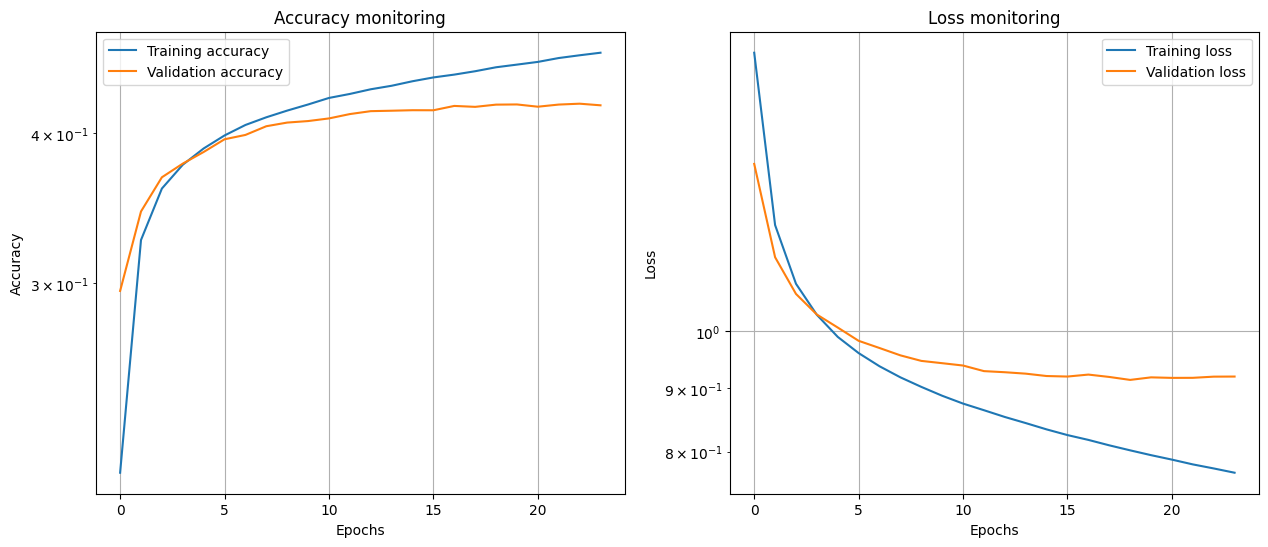

In [15]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax.plot(history.history["accuracy"], label="Training accuracy")
ax.plot(history.history["val_accuracy"], label="Validation accuracy")
ax.set_title("Accuracy monitoring")
ax.grid()
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_yscale("log")


ax2.plot(history.history["loss"], label="Training loss")
ax2.plot(history.history["val_loss"], label="Validation loss")
ax2.set_title("Loss monitoring")
ax2.grid()
ax2.legend()
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epochs")
ax2.set_yscale("log")

In [16]:
save_model(model, "./models/model_2")

Model ./models/model_2.keras saved to disk


### Conclusion: We obtain the following accuracy performances:

TRAIN: 45.33%

TEST: 42.20%

The accuracies are of the same order of magnitude, indicating that the model is well trained and will have good generalization capability. The accuracies may seem low compared to usual, but it is important to consider that the model must predict a specific word among 999 others based on the previous sequence and an image. Additionally, image captions can vary greatly from one person to another, so for the task at hand, the model's performance is satisfactory.


## Model Evaluation

**Finally, we will use the recurrent network to generate a caption for a test image and qualitatively analyze the result.** The image dataset can be downloaded on the Drive also.

**N.B.: During testing, we only have an image, and the system will iteratively produce a sequence of words starting from the "<start>" symbol until it generates the end-of-sequence symbol "<end>".**

We will start by loading a trained model, the test data, and the vector embeddings with the reduced dictionary:


In [17]:
# LOADING MODEL
model = load_model("./models/model_2")

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [18]:
# LOADING TEST DATA
X_test = tdp.X_test
Y_test = tdp.Y_test


outfile = f"./data/Caption_Embeddings_{nbkeep}.p"
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
indexwords = {}
for i in range(len(listwords)):
    indexwords[listwords[i]] = i

**We will then select an image from the test set, display it, as well as a caption from the annotations.**



In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
ind = np.random.randint(X_test.shape[0])

filename = "./data/flickr_8k_test_dataset.txt"

imname = tdp.test_dataframe.iloc[ind]["image_id"]
print(f"image name={imname} caption={tdp.test_dataframe.iloc[ind]['captions']}")
dirIm = "./Flicker8k_Dataset/"

img = mpimg.imread(dirIm + imname)
plt.figure(dpi=100)
plt.imshow(img)
plt.axis("off")
plt.show()

**To make the prediction, we will start with the first element of the sequence (_i.e._ containing the image and the "<start>" symbol), and perform the prediction:**



In [21]:
pred = model.predict(X_test[ind : ind + 1, :, :], verbose=0)

**We will then generate multiple captions by sampling the next word from the posterior distribution derived from the softmax**. Once the next word is sampled, we place its embedding vector as the input for the next element of the sequence, and the prediction continues (until the end-of-sequence symbol "<end>" is reached).
We can then complete the following code to generate the captions:


In [22]:
nbGen = 5
temperature = 0.1  # Temperature param for peacking soft-max distribution

for s in range(nbGen):
    wordpreds = "Caption n° " + str(s + 1) + ": "
    indpred = sampling(pred[0, 0, :], temperature)
    wordpred = listwords[indpred]
    wordpreds += str(wordpred) + " "

    X_test[ind : ind + 1, 1, 100:202] = embeddings[indpred]

    cpt = 1
    while str(wordpred) != "<end>" and cpt < 30:
        pred = model.predict(X_test[ind : ind + 1, :, :], verbose=0)
        indpred = sampling(pred[0, cpt, :], temperature)
        wordpred = listwords[indpred]
        wordpreds += str(wordpred) + " "
        cpt += 1
        X_test[ind : ind + 1, cpt, 100:202] = embeddings[indpred]

    print(wordpreds)

Caption n° 1: a man in a white shirt and a white headband is holding a stick in his mouth . <end> 
Caption n° 2: a man in a white shirt and a white headband is holding a stick in the air . <end> 
Caption n° 3: a man in a white shirt and a white headband is holding a stick in his mouth . <end> 
Caption n° 4: a man in a white shirt and a white headband is holding a stick in the air . <end> 
Caption n° 5: a man wearing a blue headband is holding a basketball . <end> 


## Results:

**Present the captioning results on different images.** You can test with a simplified vocabulary of 100 (or 1000) words.
**Finally, we will calculate the BLEU score metric after determining the predictions for all the examples.** You can use the following code as a basis:


In [23]:
# LOADING TEST DATA
# nbkeep = 100
nbkeep = 1000
X_test = tdp.X_test
Y_test = tdp.Y_test

# # LOADING MODEL
model = load_model("./models/model_2")

# COMPILING MODEL
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
scores_test = model.evaluate(X_test, Y_test, verbose=1)
print("PERFS TEST: %s: %.2f%%" % (model.metrics_names[1], scores_test[1] * 100))

# LOADING TEXT EMBEDDINGS
outfile = f"./data/Caption_Embeddings_{nbkeep}.p"
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
indexwords = {}
for i in range(len(listwords)):
    indexwords[listwords[i]] = i

# COMPUTING CAPTION PREDICTIONS ON TEST SET
predictions = []
nbTest = X_test.shape[0]
for i in tqdm(
    range(0, nbTest, 5),
    desc="COMPUTING CAPTION PREDICTIONS ON TEST SET...",
    leave=False,
):
    pred = model.predict(X_test[i : i + 1, :, :], verbose=0)
    wordpreds = []
    indpred = np.argmax(pred[0, 0, :])
    wordpred = listwords[indpred]
    wordpreds.append(str(wordpred))
    X_test[i, 1, 100:202] = embeddings[indpred]
    cpt = 1
    while str(wordpred) != "<end>" and cpt < (X_test.shape[1] - 1):
        pred = model.predict(X_test[i : i + 1, :, :], verbose=0)
        indpred = np.argmax(pred[0, cpt, :])
        wordpred = listwords[indpred]
        if wordpred != "<end>":
            wordpreds.append(str(wordpred))
            cpt += 1
        X_test[i, cpt, 100:202] = embeddings[indpred]

    if i % 1000 == 0:
        print("i=" + str(i) + " " + str(wordpreds))

    predictions.append(wordpreds)

# LOADING GROUD TRUTH CAPTIONS ON TEST SET
references = []
filename = "./data/flickr_8k_test_dataset.txt"
df = pd.read_csv(filename, delimiter="\t")
iter = df.iterrows()

ccpt = 0
for i in tqdm(
    range(nbTest // 5), total=nbTest // 5, desc="Caption images...", leave=False
):
    captions_image = []
    for j in range(5):
        x = iter.__next__()
        ll = x[1][1].split()
        caption = [ll[k] for k in range(1, len(ll) - 1)]

    captions_image.append(caption)
    ccpt += 1

    references.append(captions_image)

157/157 [==============================] - 14s 73ms/step - loss: 0.9056 - accuracy: 0.4220
PERFS TEST: accuracy: 42.20%


COMPUTING CAPTION PREDICTIONS ON TEST SET...:   0%|          | 1/1000 [00:04<1:06:44,  4.01s/it]

i=0 ['a', 'brown', 'dog', 'is', 'jumping', 'over', 'a', 'blue', 'blue', 'and', 'white', 'dog', '.']


COMPUTING CAPTION PREDICTIONS ON TEST SET...:  20%|██        | 201/1000 [04:43<17:00,  1.28s/it]

i=1000 ['a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', '.']


COMPUTING CAPTION PREDICTIONS ON TEST SET...:  40%|████      | 401/1000 [08:50<11:34,  1.16s/it]

i=2000 ['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'walking', 'on', 'a', 'beach', '.']


COMPUTING CAPTION PREDICTIONS ON TEST SET...:  60%|██████    | 601/1000 [12:39<07:12,  1.08s/it]

i=3000 ['a', 'young', 'boy', 'in', 'a', 'pink', 'shirt', 'is', 'jumping', 'on', 'a', 'ramp', '.']


COMPUTING CAPTION PREDICTIONS ON TEST SET...:  80%|████████  | 801/1000 [17:03<03:59,  1.20s/it]

i=4000 ['a', 'little', 'boy', 'in', 'a', 'blue', 'shirt', 'is', 'jumping', 'into', 'a', 'pool', '.']


In [ ]:
# COMPUTING BLUE-1, BLUE-2, BLUE-3, BLUE-4
blue_scores = np.zeros(4)
weights = [
    [1, 0, 0, 0],
    [0.5, 0.5, 0, 0],
    [1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0, 0],
    [1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0],
]

for i in range(4):
    blue_scores[i] = nltk.translate.bleu_score.corpus_bleu(
        references,
        predictions,
        weights=(weights[i][0], weights[i][1], weights[i][2], weights[i][3]),
    )
    print("blue_score - " + str(i) + " = " + str(blue_scores[i]))

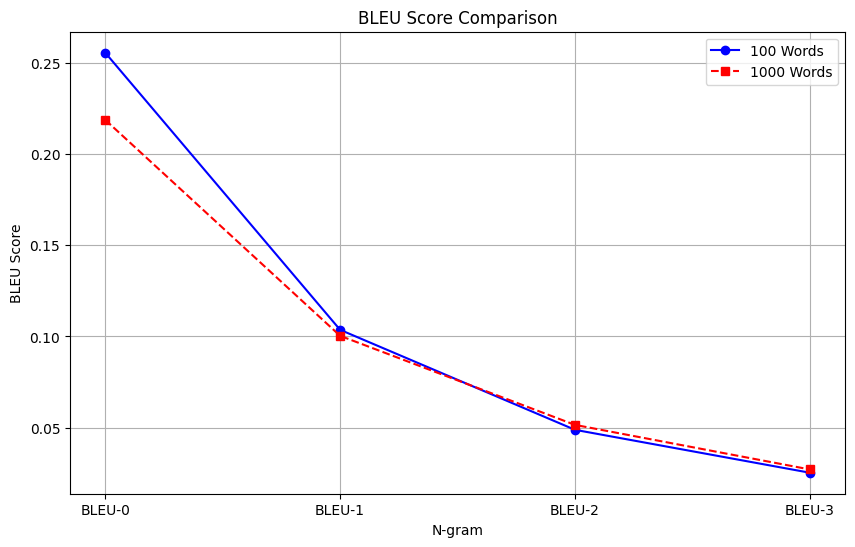

In [25]:
import matplotlib.pyplot as plt

# BLEU scores for 100 words and 1000 words
bleu_scores_100 = [0.2553865077618831, 0.10362597459292663, 0.048865477696215076, 0.025357157335902904]
bleu_scores_1000 = [0.21860903521174174, 0.10033962556253694, 0.05156157376080136, 0.02715263719137014]

# n-gram labels
n_grams = ['BLEU-0', 'BLEU-1', 'BLEU-2', 'BLEU-3']

# Plotting the BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(n_grams, bleu_scores_100, marker='o', linestyle='-', color='b', label='100 Words')
plt.plot(n_grams, bleu_scores_1000, marker='s', linestyle='--', color='r', label='1000 Words')

# Adding title and labels
plt.title('BLEU Score Comparison')
plt.xlabel('N-gram')
plt.ylabel('BLEU Score')
plt.grid(True)

# Adding legend
plt.legend()

# Show plot
plt.show()

The BLEU score is an indicator of similarity between a tested text and a reference text. It is calculated as the sum of n-grams that are the subsequences present in the correct order in the tested text based on the reference text. We use the BLEU score rather than accuracy because even a human can use different adjectives to describe an image, so the caption is not unique. If we used accuracy, it would not be representative of the model's ability to provide an 'acceptable' caption that a human could have given.

For 100 words:

- blue_score - 0 = 0.27460326663569296
- blue_score - 1 = 0.11625152150531921
- blue_score - 2 = 0.05652946631014997
- blue_score - 3 = 0.028893626899452605

The BLEU scores logically decrease with increasing n-grams. However, we observe that the model with 100 words has better performance for small n, while the model with 1000 words is more accurate for longer word sequences (n-grams with large n).


# Sources :


<a id='dblp-journals-corr-simonyanz14a'></a>
\[SZ15\] Karen Simonyan and Andrew Zisserman. Very deep convolutional networks for large-scale image recognition. In _International Conference on Learning Representations (ICLR)_. 2015.

<a id='vinyalstbecvpr2015'></a>
\[VTBE15\] Oriol Vinyals, Alexander Toshev, Samy Bengio, and Dumitru Erhan. Show and tell: A neural image caption generator. In _Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)_. 2015.
